# <div align="center">Personality Type Prediction</div>

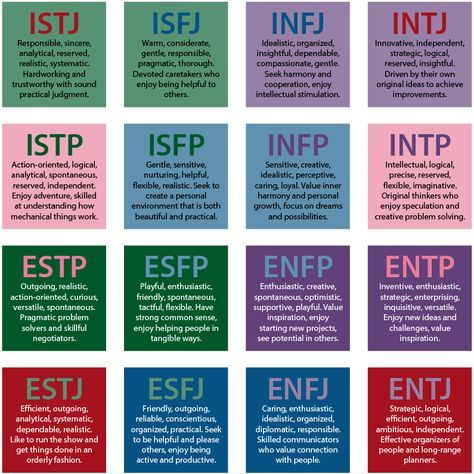

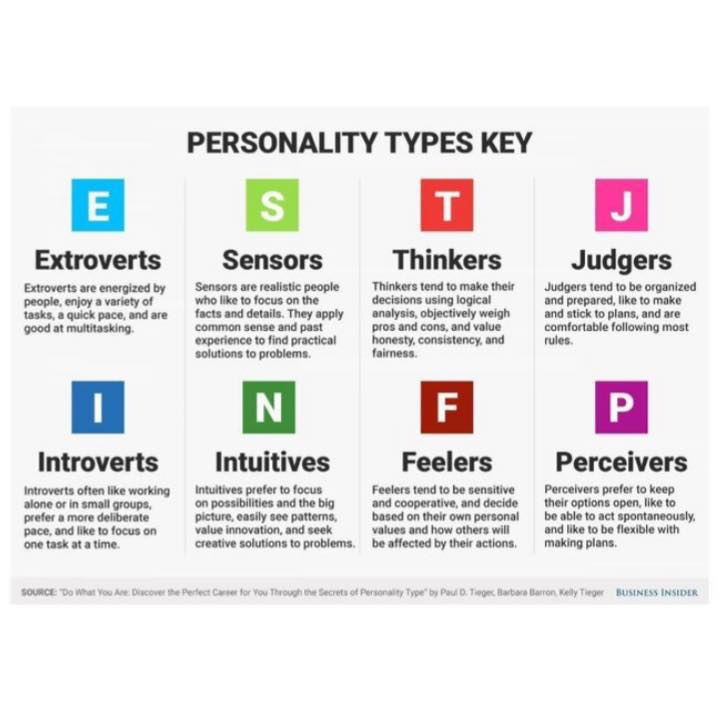

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns" , None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import random
import os
from tqdm import notebook
import gc
from string import punctuation
import chardet
import re
from datetime import datetime

from sklearn.pipeline import Pipeline , make_pipeline

np.random.seed(0)
random.seed(0)
pd.set_option("display.max_columns" , None)

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer , PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
FILE_PATH = "../input/mbti-type/mbti_1.csv"
try:
    #import data
    data = pd.read_csv(FILE_PATH)
except Exception:
    with open(FILE_PATH , "rb") as f:
        encoding = chardet.detect(f.read(10000))

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
plt.rcParams["font.size"] = 14

In [ ]:
plt.figure(figsize=(13,9))
sns.countplot(data.type);

There are 4 Personality Preferences each with 2 sub-category each (the two sub-category are of negating personalities so an Individual can only fall into one), in which individuals falls into a sub-category in the 4 preferences:
1. Introverts or Extroverts
2. Intuitives or Sensors (Sensitive)
3. Feelers(Emotional) or Thinkers
4. Judgers(Judgemental) or Perceivers(Perceiving)

So for example a person can be an **introvert** who is **sensitive** and **thinks** and is **judgemental**

We can see the way a person falls into 4 categories

In [ ]:
data.head(3)

In [ ]:
# #Lowercase ALL
# data["posts"] = data.posts.str.lower()
# #Strip the strings of spaces then apostrophe then  spaces again
# data["posts"] = data["posts"].str.strip()
# data["posts"] = data["posts"].str.strip("'")
# data["posts"] = data["posts"].str.strip()
#Strip the type feature of spaces

In [ ]:
# Just striping the string incase of any whitespace before or after the string
data["type"] = data["type"].str.strip()
# Seperate the the label into four different parts
target_multi_label = data["type"].str.split("" , expand=True)
target_multi_label = target_multi_label.iloc[: , 1:-1]
target_multi_label.columns = ["Personality-1","Personality-2","Personality-3","Personality-4"]
data = pd.concat([data,target_multi_label] , axis=1)

In [ ]:
data.head()

There are 2 unique types of Personalities in each column(feature)...this could be 2 negating(two opposite personalities), so they were put together in the same column

In [ ]:
# Let's map them to their actual meaning to make more sense out of it
personality_map = {
    "I":"Introvert",
    "E":"Extrovert",
    "N":"Intuitive",
    "S":"Sensitive",
    "F":"Emotional",
    "T":"Thinker",
    "J":"Judgemental",
    "P":"Perceiving"
}

for col in data.loc[: , "Personality-1":"Personality-4"].columns:
    data[col] = data[col].map(personality_map)

In [ ]:
data.head()

In [ ]:
personalities = data.loc[: , "Personality-1":"Personality-4"].columns
for personality in personalities:
    sns.countplot(data[personality])
    plt.show()

### Data Preprocessing

#### Cleaning our data

In [ ]:
def clean_data(text,clean_stopwords=True,clean_puntuation=True,clean_numbers=True):
    text = text.lower()
    text = text.strip()
    text = text.strip("'")
    text = text.strip()
    pattern = pattern = r"\|\|\|"
    f = lambda x : re.sub(pattern , " " , x)
    text = f(text)
    #Clean web links
    pattern = r"(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"
    f = lambda x: re.sub(pattern , "" , x)
    text = f(text)
    if clean_stopwords == True:
        #Clean Stopwords
        stopword = r"|".join([f"\s{word}\s" for word in stopwords.words("english")])
        f = lambda x : re.sub(stopword, " " , x)
        text = f(text)
    if clean_puntuation == True:
        #Clean punctuations
        #Let's not remove apostrohspe "'' so our text can make more sense
        punctuations = punctuation.replace("'" , "")
        punctuations = f"[{punctuations}]"
        f = lambda x : re.sub(punctuations , "" , text)
        text = f(text)
    if clean_numbers == True:
        #Clean Numbers
        f = lambda x : re.sub(r"[0-9]+" , "" , x)
        text = f(text)
    return text

In [ ]:
data["clean-posts"] = data["posts"].apply(clean_data)

In [ ]:
data.head()

In [ ]:
introverts_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-1"] == "Introvert"]])
extroverts_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-1"] == "Extrovert"]])
intutives_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-2"] == "Intuitive"]])
sensitive_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-2"] == "Sensitive"]])
emotional_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-3"] == "Emotional"]])
thinkers_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-3"] == "Thinker"]])
judgemental_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-4"] == "Judgemental"]])
perceivers_clean_text_corpus = " ".join([text for text in data["clean-posts"][data["Personality-4"] == "Perceiving"]])

In [ ]:
introverts_word_cloud = WordCloud(random_state=0).generate(introverts_clean_text_corpus)
extroverts_word_cloud = WordCloud(random_state=0).generate(extroverts_clean_text_corpus)
intuitives_word_cloud = WordCloud(random_state=0).generate(intutives_clean_text_corpus)
sensitive_word_cloud = WordCloud(random_state=0).generate(sensitive_clean_text_corpus)
judgemental_word_cloud = WordCloud(random_state=0).generate(judgemental_clean_text_corpus)
perceivers_word_cloud = WordCloud(random_state=0).generate(perceivers_clean_text_corpus)

In [ ]:
fig , ax = plt.subplots(3,2,figsize=(30,50))
ax = ax.flatten()

ax[0].imshow(introverts_word_cloud)
ax[0].set_title("Introverts" , fontsize = 20)
ax[0].axis(False)

ax[1].imshow(extroverts_word_cloud)
ax[1].set_title("Extroverts" , fontsize = 20)
ax[1].axis(False)

ax[2].imshow(intuitives_word_cloud)
ax[2].set_title("Intuitives" , fontsize = 20)
ax[2].axis(False)

ax[3].imshow(sensitive_word_cloud)
ax[3].set_title("Sensitives" , fontsize = 20)
ax[3].axis(False)

ax[4].imshow(judgemental_word_cloud)
ax[4].set_title("Judgemental" , fontsize = 20)
ax[4].axis(False)

ax[5].imshow(perceivers_word_cloud)
ax[5].set_title("Perceivers" , fontsize = 20)
ax[5].axis(False)

plt.show()

### Let's Split into Train and Test

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

In [ ]:
train , test = train_test_split(data , test_size=0.2 , shuffle = False)
train , val = train_test_split(train , test_size=0.1 , shuffle=False)

In [ ]:
train.shape , val.shape , test.shape

### Let's create the Bag of Words vectors and the Tfidf vectors

In [ ]:
#For Bag of Words Vector
train_bow = countVectorizer.fit_transform(train["clean-posts"])
val_bow = countVectorizer.transform(val["clean-posts"])
test_bow = countVectorizer.transform(test["clean-posts"])

#For Tfidf Vector
train_tfidf = tfidfVectorizer.fit_transform(train["clean-posts"])
val_tfidf = tfidfVectorizer.transform(val["clean-posts"])
test_tfidf = tfidfVectorizer.transform(test["clean-posts"])

In [ ]:
train_bow.shape , val_bow.shape , test_bow.shape

In [ ]:
train_tfidf.shape , val_tfidf.shape , test_tfidf.shape

## Modelling

## One versus Rest

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsOneClassifier , OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score , log_loss , confusion_matrix , classification_report

In [ ]:
y_train = train.loc[: , "Personality-1":"Personality-4"].values
y_val = val.loc[: , "Personality-1":"Personality-4"].values
y_test = test.loc[: , "Personality-1":"Personality-4"].values

mulitLabelBinarizer = MultiLabelBinarizer()

y_train = mulitLabelBinarizer.fit_transform(y_train)
y_val = mulitLabelBinarizer.transform(y_val)
y_test = mulitLabelBinarizer.transform(y_test)

classes = mulitLabelBinarizer.classes_

### Bag of Words

In [ ]:
mulitLabelBinarizer.classes_

In [ ]:
y_train.shape

In [ ]:
len(y_train[: , 0])

### One versus Rest First Approach

In [ ]:
for num , personalti in enumerate(mulitLabelBinarizer.classes_):
    X = train_bow
    y = y_train[: , num]
    lr = LogisticRegression()
    lr.fit(X , y)
    val_pred = lr.predict(val_bow)
    test_pred = lr.predict(test_bow)
    val_score = precision_score(y_val[:,num] , val_pred)
    test_score = precision_score(y_test[:,num] , test_pred)
    print(f"Processing for {personalti}")
    print(f"Validation Score: {val_score}")
    print(f"Test Score: {test_score}\n")

### One Versus Rest Second Approach

In [ ]:
ovr = OneVsRestClassifier(MultinomialNB() , n_jobs = -1)
ovr.fit(train_bow , y_train)

In [ ]:
#Validation
val_pred = ovr.predict(val_bow)
val_pred_proba = ovr.predict_proba(val_bow)
# pd.DataFrame(val_pred , columns = classes)

In [ ]:
#Test
test_pred = ovr.predict(test_bow)
test_pred_proba = ovr.predict_proba(test_bow)
# pd.DataFrame(test_pred , columns=classes)

In [ ]:
def check_scores(y_true , y_pred):
    accuracy = accuracy_score(y_true , y_pred)
    print(f"Accuracy Score: {accuracy}")
    precision = precision_score(y_true , y_pred , average="samples")
    print(f"Precision Score: {precision}")
    recall = recall_score(y_true , y_pred , average="samples")
    print(f"Recall Score: {recall}")
    f1 = f1_score(y_true , y_pred , average="samples")
    print(f"F1 Score: {f1}")

In [ ]:
check_scores(y_val , val_pred)

## Tfidf

In [ ]:
ovr = OneVsRestClassifier(MultinomialNB() , n_jobs = -1)
ovr.fit(train_tfidf , y_train)

In [ ]:
#Validation
val_pred = ovr.predict(val_tfidf)
val_pred_proba = ovr.predict_proba(val_tfidf)


In [ ]:
#Test
test_pred = ovr.predict(test_tfidf)
test_pred_proba = ovr.predict_proba(test_tfidf)

In [ ]:
check_scores(y_val , val_pred)